In [1]:
import os
import time
import torch
from torch import nn
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import datasets
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split


random_seed = 42
torch.manual_seed(random_seed)
BATCH_SIZE = 256
NUM_WORKERS = 0
SHUFFLE = True
PIN_MEMORY = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:{}'.format(device))



Device:cuda


In [2]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="~/torch_datasets", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [3]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [4]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [5]:
class GAN(pl.LightningModule):
    def __init__(self,latent_dim=100,lr = 0.0002):
        super().__init__()
        self.save_hyperparameters()
        
        
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        
        #random noise
        self.validation_z = torch.rand(6,self.hparams.latent_dim)
        
        
    def forward(self,z):
        return self.generator(z)
    
    def advsarial_loss(self,y_hat,y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self,batch,batch_idx,optimizer_idx):
        real_imgs,_ = batch
        #log_dict = {}
        #sample noise 
        z= torch.rand(real_imgs[0],self.hparams.latent_dim)
        z = z.type_as(real_imgs)
        
        #train generator: max log(D(G(x)))
        if optimizer_idx ==0:
            fake_imgs = self(z) 
            y_hat = self.discriminator(fake_imgs)

            y = torch.ones(real_imgs.size(0),1)
            y = y.type_as(real_imgs)
            
            g_loss = self.advsarial_loss(y_hat,y)
            
            log_dict = {"g_loss":g_loss}
            return {"g_loss":g_loss, "progress_bar":log_dict,"log":log_dict}
        
        #Train discriminator: max log (D(x)) +log(1-D(G(z)))
        if optimizer_idx ==1 :
            
            #how well can it label as real
            y_hat_real = self.discriminator(real_imgs)
            
            y_real = torch.ones(real_imgs.size(0),1)
            y = y_real.type_as(real_imgs)
            
            real_loss = self.advsarial_loss(y_hat_real,y_hat)
            
            #how well can it label as fake
            y_hat_fake = self.discriminator(self(z).detatch())
            
            y_fake = torch.zeros(real_imgs.size(0),1)
            y_fake = y_fake.type_as(real_imgs)
            
            fake_loss = self.advsarial_loss(y_hat_fake,y_fake)
            
            d_loss = (real_loss + fake_loss)/2
            log_dict = {"g_loss":d_loss}
            return {"g_loss":d_loss, "progress_bar":log_dict,"log":log_dict}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters,lr = lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters,lr = lr)
        return [opt_g,opt_d] ,[]
    
    
    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()
        
        print('epoch', self.current_epoch) 
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, 1+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach() [1, 0, :, :], cmap='gray_r', interpolation='none')
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
            plt.show()
    
    def on_train_epoch_end(self):
        self.plot_imgs()
        return
        
    
    
        

In [6]:
model = GAN()
dm = MNISTDataModule()

torch.Size([6, 100])


epoch 0


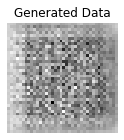

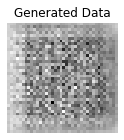

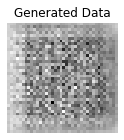

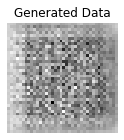

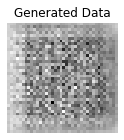

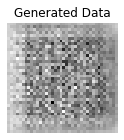

In [8]:
model.plot_imgs()

In [9]:
trainer = pl.Trainer(max_epochs=20,gpus=1)
trainer.fit(model,dm)

d:\Anaconda\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Anaconda\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
Missing logger folder: c:\Users\DIMITRIS\PycharmProjects\GANs\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TypeError: 'method' object is not iterable